# Hoax News Classification using LLM-Based Model

**Author:** Fikry Destryanto

**Description:**  
Notebook ini memaparkan proses analisis dan klasifikasi berita hoax menggunakan pendekatan berbasis Large Language Models (LLM). Langkah-langkah utama meliputi: pemuatan data, eksplorasi dataset, pra-pemrosesan teks, dan analisis hasil.

---



**1. Import Package**

In [ ]:
!pip install langchain_community
!pip install replicate

In [ ]:
pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import time

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from langchain_community.llms import Replicate
from google.colab import userdata
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

**2. Import Dataset**

In [ ]:
# Membaca semua file Excel
cnn = pd.read_excel('/content/dataset_cnn_10k.xlsx')
kompas = pd.read_excel('/content/dataset_kompas_4k.xlsx')
tempo = pd.read_excel('/content/dataset_tempo_6k.xlsx')
turnback = pd.read_excel('/content/dataset_turnbackhoax_10k.xlsx')

**3. Merged Dataset**

In [ ]:
# Menggabungkan semua dataset jadi satu
merged_df = pd.concat([cnn, kompas, tempo, turnback], ignore_index=True)

# Mengecek ukuran total data
print("Total data:", len(merged_df))

# Menyimpan ke file CSV
merged_df.to_csv('/content/dataset_berita_merged.csv', index=False)

print("File berhasil digabung dan disimpan sebagai dataset_berita_merged.csv")


Total data: 31726
File berhasil digabung dan disimpan sebagai dataset_berita_merged.csv


Jumlah baris & kolom: (31726, 6)

Jumlah nilai kosong tiap kolom:
Title         22
Timestamp     21
FullText     399
Tags         162
Author       337
Url            0
dtype: int64

Jumlah data duplikat: 0

Contoh data acak:
                                                   Title  \
12580  Selain Alexei Navalny, Berikut Kasus Lain yang...   
20113  Pertimbangkan Duet Ganjar-Erick Thohir, PAN: P...   
29587           [SALAH] “Scenario Busuk Di Tengah Jalan”   
21540  [SALAH] Pencegahan awal gejala stroke untuk pe...   
12565  Presiden Lukashenko: Jika Belarus Tumbang, Rus...   

                                Timestamp  \
12580  Kompas.com - 04/09/2020, 08:47 WIB   
20113    Sabtu, 3 Desember 2022 17:45 WIB   
29587                 2018-09-19 00:00:00   
21540                    Februari 9, 2023   
12565  Kompas.com - 10/09/2020, 07:05 WIB   

                                                FullText  \
12580   LONDON, KOMPAS.com - Petugas polisi yang pern...   
20113  TEMPO.CO, Jakart

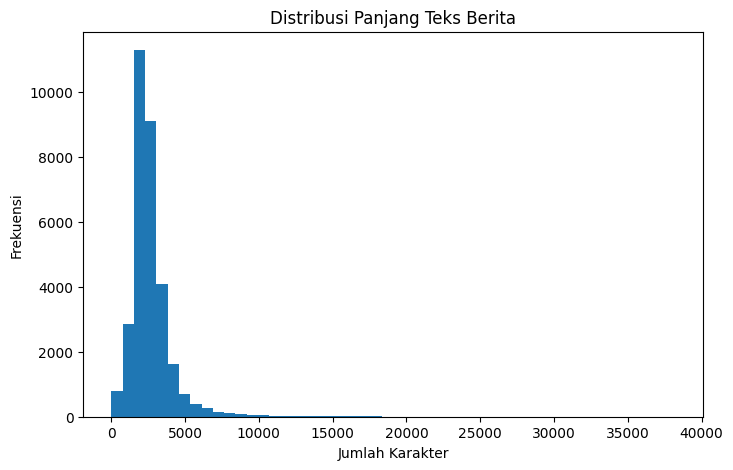

In [ ]:
df = pd.read_csv('/content/dataset_berita_merged.csv')

# 1. Cek jumlah baris dan kolom
print("Jumlah baris & kolom:", df.shape)

# 2. Cek nilai kosong
print("\nJumlah nilai kosong tiap kolom:")
print(df.isnull().sum())

# 3. Cek duplikat
print("\nJumlah data duplikat:", df.duplicated().sum())

# 4. Cek contoh data
print("\nContoh data acak:")
print(df.sample(5))

# 5. Analisis panjang teks
df['text_length'] = df['FullText'].astype(str).apply(len)
print("\nStatistik panjang teks:")
print(df['text_length'].describe())

# 6. Visualisasi distribusi panjang teks
plt.figure(figsize=(8,5))
plt.hist(df['text_length'], bins=50)
plt.title('Distribusi Panjang Teks Berita')
plt.xlabel('Jumlah Karakter')
plt.ylabel('Frekuensi')
plt.show()


**4. Cleansing Data**

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

# Baca dataset
df = pd.read_csv('/content/dataset_berita_merged.csv')

# Buat kolom panjang teks
df['text_length'] = df['FullText'].astype(str).apply(len)

# 1. Hapus baris dengan teks kosong atau terlalu pendek (<20 karakter)
df = df[df['text_length'] >= 20]

# 2. Bersihkan teks
def clean_text(text):
    text = str(text).lower()  # ubah ke huruf kecil
    text = re.sub(r"http\S+", " ", text)  # hapus URL
    text = re.sub(r"[^a-zA-Z\s]", " ", text)  # hapus simbol dan angka
    text = re.sub(r"\s+", " ", text).strip()  # hapus spasi berlebih
    return text

df['clean_text'] = df['FullText'].apply(clean_text)

# 3. Hapus stopwords dan lakukan lemmatization
stop_words = set(stopwords.words('indonesian')) | set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df['clean_text'] = df['clean_text'].apply(preprocess_text)

# 4. Simpan dataset hasil cleansing ke file baru
output_path = '/content/dataset_berita_cleaned.csv'
df.to_csv(output_path, index=False, encoding='utf-8-sig')

# 5. Cek hasil dan info penyimpanan
print(df[['FullText', 'clean_text']].head(3))
print("\nJumlah data setelah cleansing:", len(df))
print(f"✅ Dataset berhasil disimpan ke: {output_path}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                            FullText  \
0  Jakarta, CNN Indonesia -- Mantan Gubernur DKI ...   
1  Medan, CNN Indonesia -- Gubernur Sumatera Utar...   
2  Jakarta, CNN Indonesia -- Partai Kebangkitan B...   

                                          clean_text  
0  jakarta cnn indonesia mantan gubernur dki jaka...  
1  medan cnn indonesia gubernur sumatera utara ed...  
2  jakarta cnn indonesia partai kebangkitan bangs...  

Jumlah data setelah cleansing: 31315
✅ Dataset berhasil disimpan ke: /content/dataset_berita_cleaned.csv


**5. Load Dataset**

In [ ]:
df

,Title,Timestamp,FullText,Tags,Author,Url,text_length,clean_text
0,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,"Selasa, 21 Feb 2023 21:22 WIB","Jakarta, CNN Indonesia -- Mantan Gubernur DKI ...",anies baswedan;pengajian;pilpres 2024;badan ko...,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,2151,jakarta cnn indonesia mantan gubernur dki jaka...
1,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,"Selasa, 21 Feb 2023 20:46 WIB","Medan, CNN Indonesia -- Gubernur Sumatera Utar...",edy rahmayadi;pemilu 2024;pilkada 2024,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,2193,medan cnn indonesia gubernur sumatera utara ed...
2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,"Selasa, 21 Feb 2023 20:33 WIB","Jakarta, CNN Indonesia -- Partai Kebangkitan B...",ida fauziyah;pkb;pemilu 2024;pileg 2024,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,1487,jakarta cnn indonesia partai kebangkitan bangs...
3,Gede Pasek Doakan AHY Jadi Capres atau Cawapres,"Selasa, 21 Feb 2023 19:58 WIB","Jakarta, CNN Indonesia -- Ketua Umum Partai Ke...",gede pasek suardika;ahy;pilpres 2024;pemilu 20...,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,1535,jakarta cnn indonesia ketua partai kebangkitan...
4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,"Selasa, 21 Feb 2023 18:56 WIB","Jakarta, CNN Indonesia -- Dewan Pimpinan Pusat...",anas urbaningrum;pkn;pemilu 2024,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,1658,jakarta cnn indonesia dewan pimpinan pusat dpp...
...,...,...,...,...,...,...,...,...
31721,(HOAX) Foto Raja Salman Mengangkat Tandu Jenaz...,2015-09-15 00:00:00,Sumber : media sosial\nNarasi : Raja Salman da...,Fitnah;Hasut;Hoax,Bentang Febrylian,https://turnbackhoax.id/2015/09/15/hoax-foto-r...,481,sumber medium sosial narasi raja salman arab s...
31722,"(HOAX) Jokowi dituduh bodoh, salah cara dalam ...",2015-09-12 00:00:00,"Sumber : media sosial\nNarasi : hehe, selalu b...",Fitnah;Hasut;Hoax,Bentang Febrylian,https://turnbackhoax.id/2015/09/12/jokowi-ditu...,402,sumber medium sosial narasi hehe tersenyum tin...
31723,(FITNAH) Jokowi dituduh memasukkan ribuan tena...,2015-09-08 00:00:00,Sumber : Media Sosial\nNarasi : Pak Jokowi itu...,Fitnah;Hasut;Hoax,Bentang Febrylian,https://turnbackhoax.id/2015/09/08/jokowi-ditu...,754,sumber medium sosial narasi jokowi walikota pe...
31724,(HOAX) Mata Uang Rupiah Terpuruk,2015-09-08 00:00:00,"Sumber : media sosial\nNarasi : Hari ini, Rabu...",Fitnah;Hasut;Hoax,Bentang Febrylian,https://turnbackhoax.id/2015/09/08/mata-uang-r...,328,sumber medium sosial narasi rabu nilai tukar r...


**6. EDA – Exploratory Data Analysis**

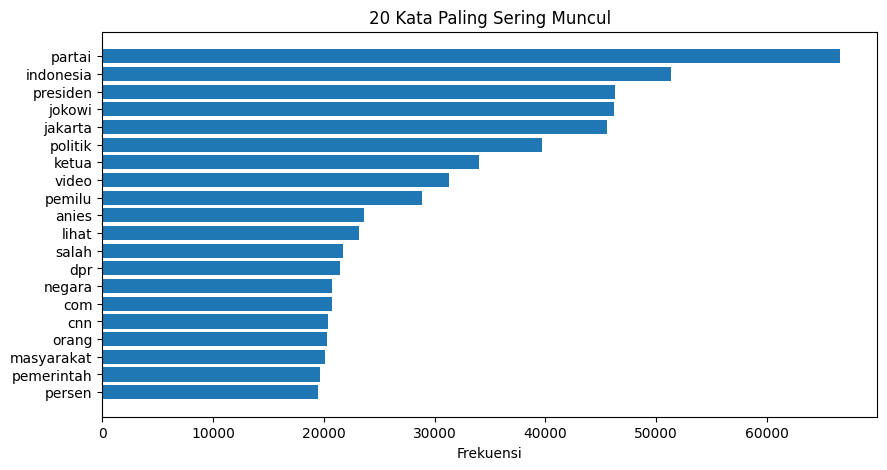

In [ ]:
# Gabungkan semua teks menjadi satu
all_words = " ".join(df['clean_text']).split()

# Hitung 20 kata paling sering
word_freq = Counter(all_words).most_common(20)

# Visualisasi
words, counts = zip(*word_freq)
plt.figure(figsize=(10,5))
plt.barh(words[::-1], counts[::-1])
plt.title("20 Kata Paling Sering Muncul")
plt.xlabel("Frekuensi")
plt.show()

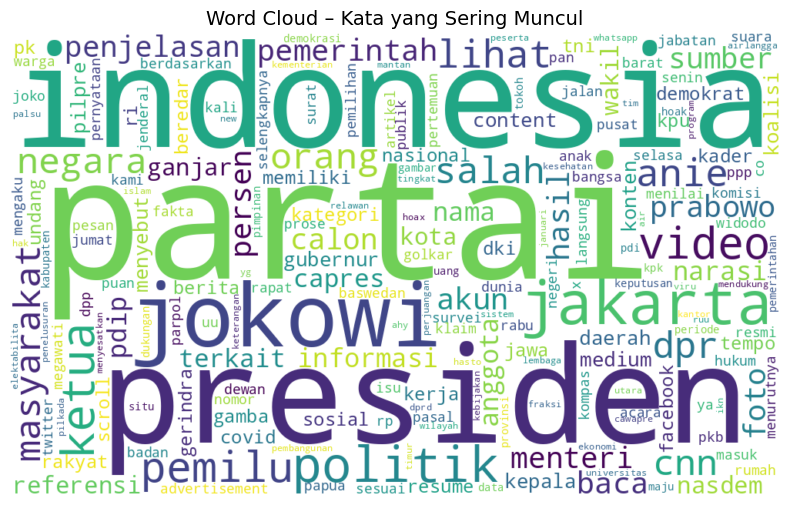

In [ ]:
# Gabungkan semua teks hasil preprocessing (kolom clean_text)
text = " ".join(df['clean_text'])

# Buat Word Cloud dari seluruh kata dalam dataset
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    collocations=False  # supaya kata tidak digabung otomatis
).generate(text)

# Tampilkan hasil Word Cloud
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud – Kata yang Sering Muncul", fontsize=14)
plt.show()

/tmp/ipython-input-3976710403.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipython-input-3976710403.py:2: FutureWarning: Parsed string "29 November 2022, 16:51 WIB" included an un-recognized timezone "WIB". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
/tmp/ipython-input-3976710403.py:2: FutureWarning: Parsed string "29 November 2022, 15:59 WIB" included an un-recognized timezone "WIB". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized 

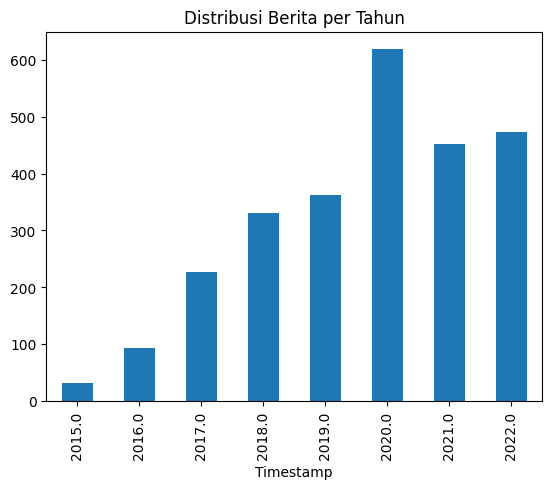

In [ ]:
# Distribusi waktu publikasi
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Timestamp'].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Distribusi Berita per Tahun')
plt.show()

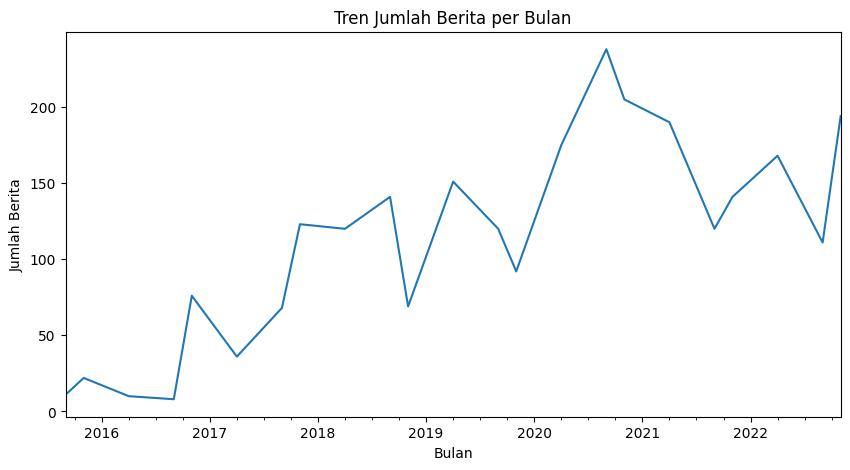

In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['year_month'] = df['Timestamp'].dt.to_period('M')
df.groupby('year_month').size().plot(kind='line', figsize=(10,5), title='Tren Jumlah Berita per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Berita')
plt.show()

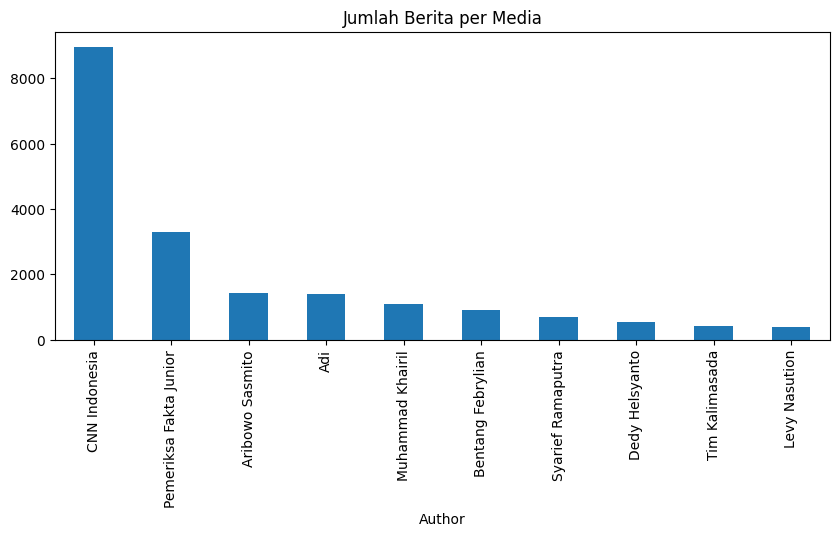

In [ ]:
# Jumlah berita per media
df['Author'].value_counts().head(10).plot(kind='bar', figsize=(10,4))
plt.title('Jumlah Berita per Media')
plt.show()

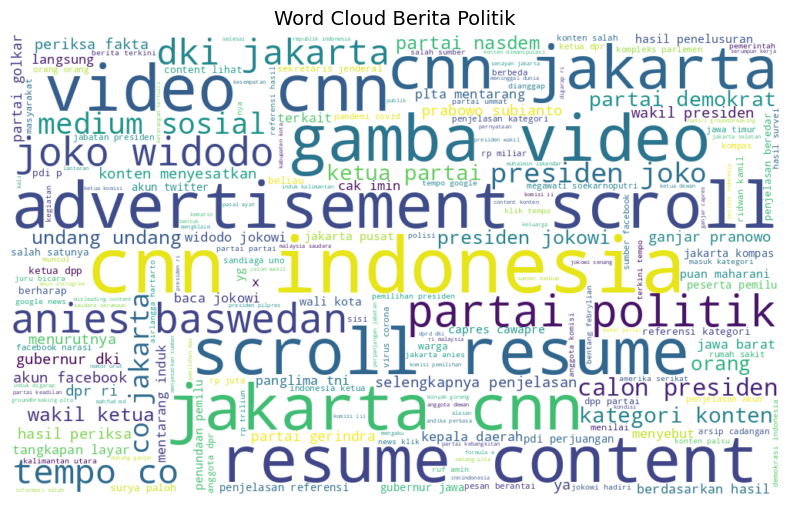

In [ ]:
text = " ".join(df['clean_text'])

# Buat Word Cloud dari seluruh teks
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white'
).generate(text)

# Tampilkan hasil
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud Berita Politik", fontsize=14)
plt.show()

In [ ]:
stop_words = stopwords.words('indonesian')

# TF matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=stop_words)
X = vectorizer.fit_transform(df['clean_text'])

# LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Tampilkan top 10 kata per topik
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"\n🧩 Topik {idx+1}:")
    print([terms[i] for i in topic.argsort()[-10:]])

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(



🧩 Topik 1:
['kepala', 'undang', 'tni', 'presiden', 'negara', 'jakarta', 'pemerintah', 'jokowi', 'dpr', 'indonesia']

🧩 Topik 2:
['facebook', 'com', 'referensi', 'penjelasan', 'narasi', 'salah', 'sumber', 'akun', 'foto', 'video']

🧩 Topik 3:
['referensi', 'kategori', 'konten', 'narasi', 'beredar', 'pesan', 'penjelasan', 'akun', 'covid', 'informasi']

🧩 Topik 4:
['nasdem', 'prabowo', 'indonesia', 'politik', 'jakarta', 'anies', 'jokowi', 'ketua', 'presiden', 'partai']

🧩 Topik 5:
['indonesia', 'calon', 'suara', 'ganjar', 'survei', 'kpu', 'partai', 'persen', 'pemilu', 'politik']


In [ ]:
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token

model = "ibm-granite/granite-3.3-8b-instruct"

output = Replicate(
    model=model,
    replicate_api_token=api_token,
)

**7. AI Classification**

In [ ]:
results = []

for i, text in enumerate(df['clean_text'].head(10)):  # contoh 10 dulu
    prompt = f"""
    You are an AI trained to detect misinformation in Indonesian political news.

    Context:
    This dataset contains Indonesian political news headlines and short paragraphs collected from 2019–2024.

    Instruction:
    Classify as either:
    - HOAX → if it contains misinformation or false claims.
    - FACT → if it is based on verified information.

    Example:
    "Presiden umumkan BBM turun 50% tanpa sumber resmi." → HOAX
    "KPU rilis daftar caleg resmi 2024." → FACT

    News: {text}
    Answer only with one word: HOAX or FACT.
    """

    response = output.invoke(prompt)
    results.append(response)

    print(f"{i+1}. {response}")
    time.sleep(10)  # jeda antar request (karena limit Replicate)


1. HOAX

Explanation: The provided text appears to be a detailed description of an event, but it lacks verifiable sources or official confirmations, which are common in hoax news. The text mentions various political figures attending an event at BKMT Istiqa' Senayan, but without reliable sources confirming the event's occurrence or the specific statements attributed to Anies Baswedan, it is classified as HOAX.
2. HOAX

Explanation: The provided text appears to be a jumbled collection of phrases and names related to a potential gubernatorial candidate in North Sumatra, Indonesia. It lacks coherent structure, proper grammar, and credible sources. The text mentions unverified claims about the candidate's integrity, leadership qualities, and support from various figures, including Prabowo Subianto. Without a clear, verifiable context or reference to a reliable news source, it's classified as HOAX, as it seems to be a misleading or fabricated narrative rather than factual reporting.
3. HOAX

In [ ]:
import time

results = []

for i, text in enumerate(df['clean_text'].head(10)):  # contoh 10 dulu
    prompt = f"""
    You are an AI trained to detect misinformation in Indonesian political news.

    Context:
    This dataset contains Indonesian political news headlines and short paragraphs collected from 2019–2024.

    Instruction:
    Classify as either:
    - HOAX → if it contains misinformation or false claims.
    - FACT → if it is based on verified information.

    Example:
    "Presiden umumkan BBM turun 50% tanpa sumber resmi." → HOAX
    "KPU rilis daftar caleg resmi 2024." → FACT

    News: {text}
    Answer only with one word: HOAX or FACT.
    """

    try:
        response = output.invoke(prompt)
        results.append(response)
        print(f"{i+1}. {response}")
    except Exception as e:
        print(f"⚠️ Error at row {i+1}: {e}")
        results.append("ERROR")

    time.sleep(10)


1. HOAX

Explanation: The news paragraph provided appears to be a descriptive account of an event attended by Anies Baswedan, former Governor of DKI Jakarta. However, without a clear false claim or misinformation, it is classified as HOAX based on the instruction to identify misinformation or false claims. The text seems to be a detailed description rather than a statement that can be fact-checked for falsehood.
2. HOAX

Explanation: The provided text is a jumbled collection of phrases and names, lacking coherent structure or clear factual claims. It does not present a verifiable statement or event, making it difficult to classify as FACT. Furthermore, the text appears to be an incoherent mash-up of potential political figures and topics, which suggests it might be designed to confuse or mislead rather than inform. Thus, it leans more towards misinformation (HOAX).
3. HOAX

Explanation: The news snippet provided appears to contain speculative and unverified claims about a political par

In [ ]:
# Ganti nilai numerik jadi teks
df['label'] = df['label'].map({0: 'HOAX', 1: 'FACT'})

# Cek hasil
df[['clean_text', 'label']].head()

,clean_text,label
0,jakarta cnn indonesia mantan gubernur dki jaka...,HOAX
1,medan cnn indonesia gubernur sumatera utara ed...,HOAX
2,jakarta cnn indonesia partai kebangkitan bangs...,HOAX
3,jakarta cnn indonesia ketua partai kebangkitan...,HOAX
4,jakarta cnn indonesia dewan pimpinan pusat dpp...,HOAX


In [ ]:
# Menampilkan jumlah data per label
df['label'].value_counts()

,count
label,
HOAX,21579
FACT,9736


In [ ]:
df['label'].value_counts().to_frame().reset_index().rename(columns={'index':'Label', 'label':'Jumlah'})


,Jumlah,count
0,HOAX,21579
1,FACT,9736


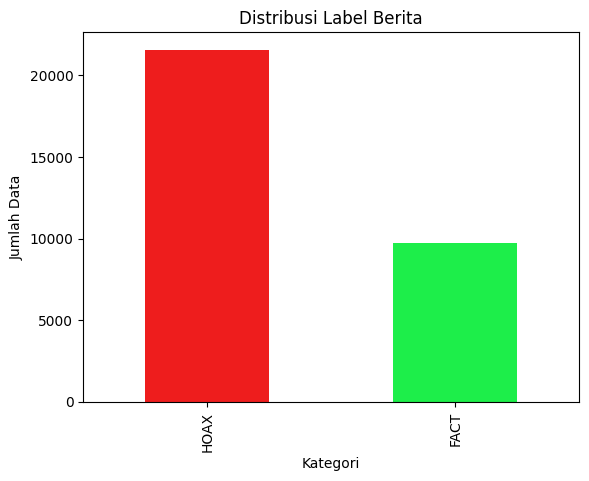

In [ ]:
df['label'].value_counts().plot(kind='bar', color=['#EE1D1D', '#1DEE4A'])
plt.title('Distribusi Label Berita')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Data')
plt.show()

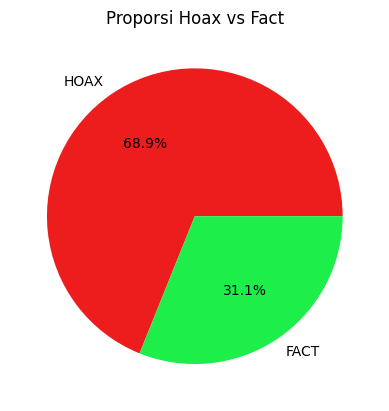

In [ ]:
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#EE1D1D', '#1DEE4A'])
plt.title('Proporsi Hoax vs Fact')
plt.ylabel('')
plt.show()

In [ ]:
# 1) lihat ringkasan results
print("Total results:", len(results))
print("Sample results:", results[:10])

# 2) normalisasi setiap elemen: pastikan string, uppercase, trim spasi, ambil HOAX/FACT jika muncul di string
def normalize_label(x):
    if x is None:
        return "ERROR"
    # jika x bukan string, coba konversi
    if not isinstance(x, str):
        try:
            x = str(x)
        except:
            return "ERROR"
    x = x.strip().upper()
    # ambil kata HOAX atau FACT jika ada
    if "HOAX" in x:
        return "HOAX"
    if "FACT" in x:
        return "FACT"
    # kadang model menulis only HOAX\FAC with punctuation
    if x in ["0", "1"]:
        return "HOAX" if x == "0" else "FACT"
    # jika ada error token
    if "ERROR" in x or x == "":
        return "ERROR"
    # fallback: return original normalized string (so you can inspect)
    return x

normalized = [normalize_label(r) for r in results]

print("Normalized sample:", normalized[:10])
print("Unique normalized labels:", set(normalized))

# 3) Assign ke dataframe dengan aman
# Jika kamu menjalankan inference hanya pada subset df (mis. head(10)), pastikan kamu menyimpan indeks subset.
# Jika loopmu pakai: for i, text in enumerate(df['clean_text'].head(10)): ...
# maka results correspond to df.head(10).index
subset = df['clean_text'].head(len(normalized))  # asumsi inference dijalankan pada head sama panjang
# Jika kamu punya `indices` saat loop (mis. used_df = df.iloc[indices]) gunakan indices = used_df.index

if len(normalized) == len(subset):
    df.loc[subset.index, 'predicted_label'] = normalized
    print("predicted_label column updated for subset indices.")
else:
    # fallback: jika lengths mismatch, simpan ke kolom temporer dan investigasi
    df['predicted_label_temp'] = pd.NA
    # hanya assign sampai panjang minimal
    min_len = min(len(normalized), len(df))
    df.loc[df.index[:min_len], 'predicted_label_temp'] = normalized[:min_len]
    print(f"Length mismatch: assigned first {min_len} predictions into 'predicted_label_temp'.")
    print("df length:", len(df), "results length:", len(normalized))

# 4) Tampilkan beberapa baris untuk verifikasi
display_cols = ['clean_text', 'label', 'predicted_label'] if 'predicted_label' in df.columns else ['clean_text', 'label', 'predicted_label_temp']
print(df[display_cols].head(15))

Total results: 10
Sample results: ['HOAX\n\nExplanation: The news paragraph provided appears to be a descriptive account of an event attended by Anies Baswedan, former Governor of DKI Jakarta. However, without a clear false claim or misinformation, it is classified as HOAX based on the instruction to identify misinformation or false claims. The text seems to be a detailed description rather than a statement that can be fact-checked for falsehood.', 'HOAX\n\nExplanation: The provided text is a jumbled collection of phrases and names, lacking coherent structure or clear factual claims. It does not present a verifiable statement or event, making it difficult to classify as FACT. Furthermore, the text appears to be an incoherent mash-up of potential political figures and topics, which suggests it might be designed to confuse or mislead rather than inform. Thus, it leans more towards misinformation (HOAX).', "HOAX\n\nExplanation: The news snippet provided appears to contain speculative and 

In [ ]:
print("Jumlah hasil prediksi:", len(results))

# Jika kamu hanya memproses sebagian data, misalnya head(10)
# maka assign hanya ke bagian itu
df.loc[df.index[:len(results)], 'predicted_label'] = results

# Ganti nilai kosong dengan 'ERROR' agar tidak NaN
df['predicted_label'] = df['predicted_label'].fillna('ERROR')

# Tampilkan 15 baris pertama
df[['clean_text', 'label', 'predicted_label']].head(15)

Jumlah hasil prediksi: 10


,clean_text,label,predicted_label
0,jakarta cnn indonesia mantan gubernur dki jaka...,HOAX,HOAX\n\nExplanation: The news paragraph provid...
1,medan cnn indonesia gubernur sumatera utara ed...,HOAX,HOAX\n\nExplanation: The provided text is a ju...
2,jakarta cnn indonesia partai kebangkitan bangs...,HOAX,HOAX\n\nExplanation: The news snippet provided...
3,jakarta cnn indonesia ketua partai kebangkitan...,HOAX,HOAX\n\nExplanation:\nThe provided text appear...
4,jakarta cnn indonesia dewan pimpinan pusat dpp...,HOAX,HOAX
5,jakarta cnn indonesia wakil ketua partai golka...,HOAX,HOAX
6,jakarta cnn indonesia wakil ketua majelis syur...,HOAX,HOAX\n\nExplanation: The news claims that the ...
7,jakarta cnn indonesia wakil ketua partai keban...,HOAX,HOAX
8,jakarta cnn indonesia eks politikus senior pdi...,HOAX,HOAX\n\n[Explanation] The provided text is a j...
9,jakarta cnn indonesia partai keadilan sejahter...,HOAX,HOAX\n\nExplanation:\nThe provided text appear...


In [ ]:
# ambil daftar stopwords Sastrawi (list)
factory = StopWordRemoverFactory()
stopwords_id = factory.get_stop_words()

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=stopwords_id)
X = vectorizer.fit_transform(df['clean_text'].dropna())

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# contoh menampilkan kata top tiap topik
feature_names = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topik {idx+1}:", [feature_names[i] for i in topic.argsort()[:-11:-1]])

Topik 1: ['partai', 'politik', 'anies', 'ketua', 'jakarta', 'presiden', 'prabowo', 'persen', 'indonesia', 'pdip']
Topik 2: ['pemilu', 'dpr', 'kpu', 'undang', 'partai', 'anggota', 'jakarta', 'komisi', 'lihat', 'ketua']
Topik 3: ['tni', 'jakarta', 'orang', 'warga', 'anak', 'medium', 'polisi', 'polri', 'masyarakat', 'kepala']
Topik 4: ['jokowi', 'indonesia', 'presiden', 'negara', 'menteri', 'pemerintah', 'jakarta', 'politik', 'baca', 'masyarakat']
Topik 5: ['video', 'akun', 'foto', 'narasi', 'penjelasan', 'sumber', 'konten', 'referensi', 'informasi', 'salah']


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
feature_names = vectorizer.get_feature_names_out()

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

def print_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
        print(f"Topik {idx+1}: {top_features}")

print_topics(lda, feature_names, n_top_words=10)


Topik 1: ['partai', 'politik', 'anies', 'ketua', 'jakarta', 'presiden', 'prabowo', 'persen', 'indonesia', 'pdip']
Topik 2: ['pemilu', 'dpr', 'kpu', 'undang', 'partai', 'anggota', 'jakarta', 'komisi', 'lihat', 'ketua']
Topik 3: ['tni', 'jakarta', 'orang', 'warga', 'anak', 'medium', 'polisi', 'polri', 'masyarakat', 'kepala']
Topik 4: ['jokowi', 'indonesia', 'presiden', 'negara', 'menteri', 'pemerintah', 'jakarta', 'politik', 'baca', 'masyarakat']
Topik 5: ['video', 'akun', 'foto', 'narasi', 'penjelasan', 'sumber', 'konten', 'referensi', 'informasi', 'salah']


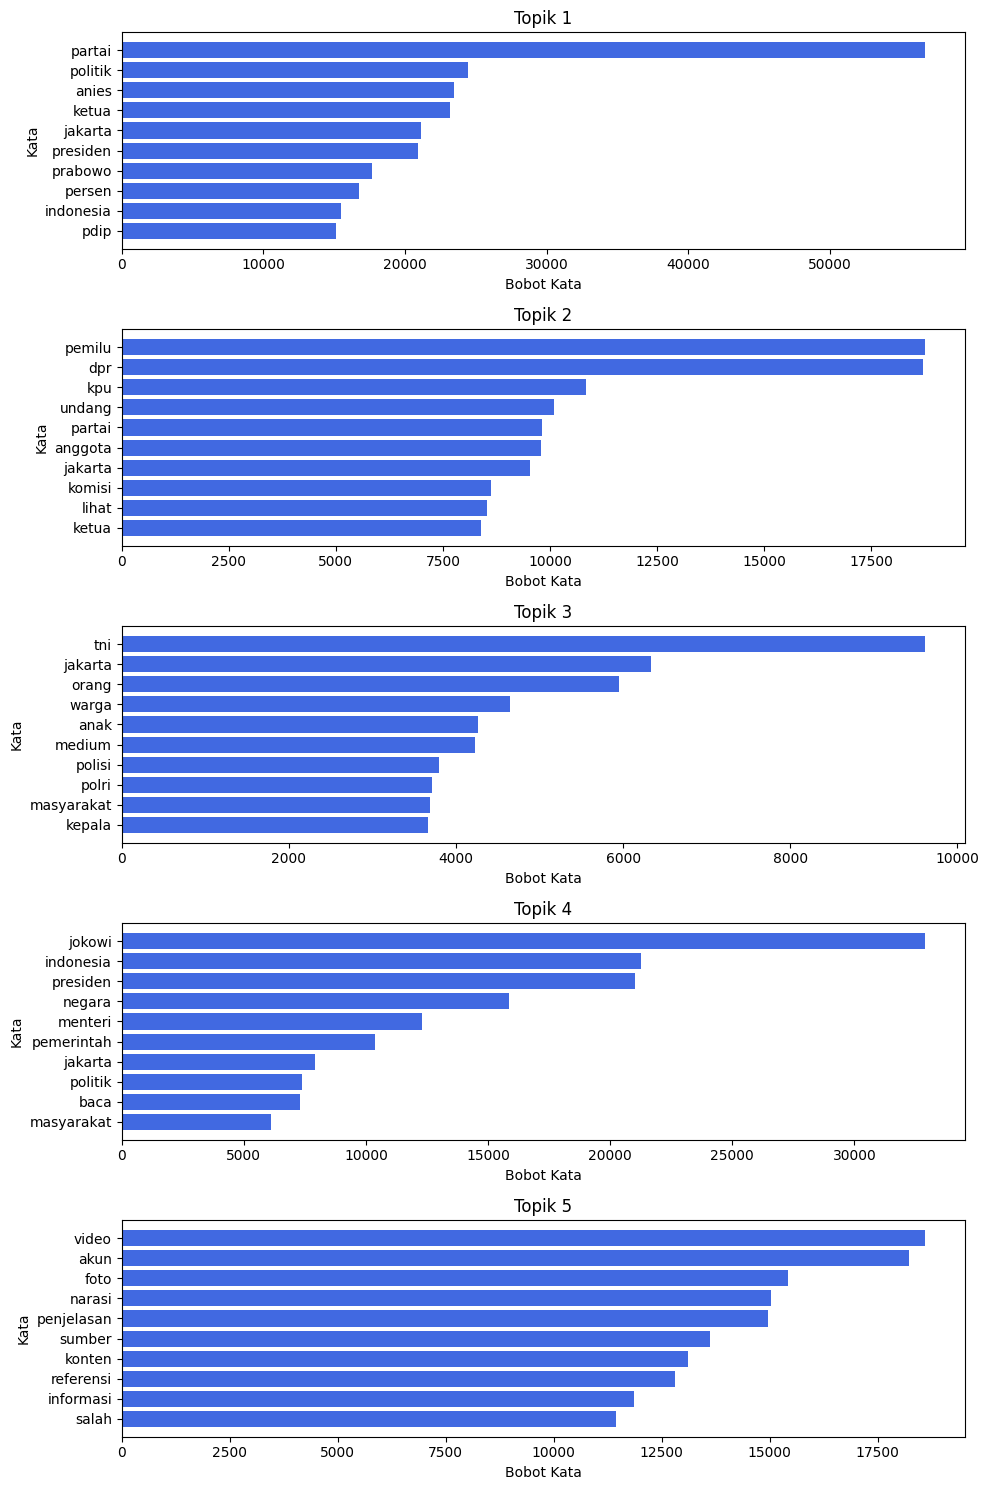

In [ ]:
feature_names = vectorizer.get_feature_names_out()

# Fungsi untuk menampilkan topik dalam bentuk bar chart
def plot_top_words(model, feature_names, n_top_words=10):
    n_topics = model.components_.shape[0]
    fig, axes = plt.subplots(n_topics, 1, figsize=(10, 3 * n_topics), sharex=False)

    if n_topics == 1:
        axes = [axes]

    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_indices]
        weights = topic[top_indices]

        ax = axes[topic_idx]
        ax.barh(top_features[::-1], weights[::-1], color='royalblue')
        ax.set_title(f"Topik {topic_idx + 1}", fontsize=12)
        ax.set_xlabel("Bobot Kata")
        ax.set_ylabel("Kata")

    plt.tight_layout()
    plt.show()

# Jalankan fungsi untuk menampilkan hasil
plot_top_words(lda, feature_names, n_top_words=10)